# Chap. 6 メタクラスと属性

## 項目４４　getメソッドやsetメソッドは使わず属性をそのまま使う

In [2]:
class Resister:
    def __init__(self, ohms):
        self.ohms = ohms
        self.voltage = 0
        self.current = 0


class VoltageResistance(Resister):
    def __init__(self, ohms):
        super().__init__(ohms)
        self._voltage = 0
        
    @property
    def voltage(self):
        return self._voltage
    
    @voltage.setter
    def voltage(self, voltage):
        self._voltage = voltage
        self.current = self._voltage / self.ohms
        
        

In [3]:
r2 = VoltageResistance(1e3)
print(f"Before: {r2.current:.2f} amps")
r2.voltage = 10
print(f"After: {r2.current:.2f} amps")

Before: 0.00 amps
After: 0.01 amps


In [6]:
class BoudedResitance(Resister):
    def __init__(self, ohms):
        super().__init__(ohms)
        
    @property 
    def ohms(self):
        return self._ohms
    
    @ohms.setter
    def ohms(self, ohms):
        if ohms <= 0:
            raise ValueError(f"ohms must be > 0; got {ohms}")
        self._ohms = ohms
        
        

In [7]:
r3 = BoudedResitance(1e3)
r3.ohms = 0

ValueError: ohms must be > 0; got 0

In [8]:
r3 = BoudedResitance(-5)

ValueError: ohms must be > 0; got -5

## 項目45 属性をリファクタリングする代わりに@propertyを考える

In [16]:
class Bucket:
    def __init__(self, period):
        self.period_delta = timedelta(seconds=period)
        self.reset_time = datetime.now()
        self.quota = 0
        
    def __repr__(self):
        return f"Bucket(quota={self.quota})"

In [17]:
def fill(bucket, amount):
    now = datetime.now()
    if now - bucket.reset_time > bucket.period_delta:
        bucket.quota = 0
        bucket.reset_time = now
    bucket.quota += amount

In [18]:
def deduct(bucket, amount):
    now = datetime.now()
    if (now - bucket.reset_time) > bucket.period_delta:
        return False # there are no water in this period
    if bucket.quota - amount < 0:
        return False # there are any water , but not enough
    bucket.quota -= amount
    return True  # there are full of bucket



In [21]:
from datetime import timedelta, datetime


class NewBucket:
    def __init__(self, period):
        self.period_delta = timedelta(seconds=period)
        self.reset_time = datetime.now()
        self.max_quota = 0
        self.quota_consumed = 0
    
    def __repr__(self):
        return (f"NewBucket(max_quota={self.max_quota})"
               f"quota_consumed={self.quota_consumed}")
    
    @property
    def quota(self):
        return self.max_quota - slef.quota_consumed
    
    @quota.setter
    def quota(self, amount):
        delta = self.max_quota - amount
        if amount == 0:
            # reset assign for new period
            self.quota_consumed = 0
            self.max_quota = 0
        elif delta < 0:
            # enter assign for new period
            assert self.max_quota >= self.quota_consumed
            self.quota_consumed += delta
            
bucket = Bucket(60)
print("Initial", bucket)
fill(bucket, 100)
print("Filled", bucket)

if deduct(bucket, 99):
    print("Had 99 quota")
else:
    print("Not enough for 99 quota")
    
print("Now", bucket)

if deduct(bucket, 3):
    print("Had 3 quota")
else:
    print("Not enough for 3 quota")
    
print("Still", bucket)

Initial Bucket(quota=0)
Filled Bucket(quota=100)
Had 99 quota
Now Bucket(quota=1)
Not enough for 3 quota
Still Bucket(quota=1)


## 項目４６　再利用可能な@propertyメソッドにディスクリプタを使う

In [22]:
class Grade:
    def __get__(self, instance, instance_type):
        pass
    def __set__(self, instance, value):
        pass
    
class Exam:
    # class property
    math_grade = Grade()
    writing_grade = Grade()
    science_grade = Grade()


exam = Exam()
exam.writing_grade = 40

In [23]:
class Grade:
    def __init__(self):
        self._value = 0
        
    def __get__(self, instance, instance_type):
        return self._value
    
    def __set__(self, instance, value):
        if not (0 <= value <= 100):
            raise ValueError("Grade must be between 0 and 100")
        self._value = value


In [24]:
class Exam:
    math_grade = Grade()
    writing_grade = Grade()
    science_grade = Grade()
    
    
first_exam = Exam()
first_exam.writing_grade = 82
first_exam.science_grade = 99
print("Writing", first_exam.writing_grade)
print("Science", first_exam.science_grade)

Writing 82
Science 99


In [26]:
second_exam = Exam()
second_exam.writing_grade = 75
print(f"Second {second_exam.writing_grade} is right")
print(f"First {first_exam.writing_grade} is wrong; "
     f"should be 82")

Second 75 is right
First 75 is wrong; should be 82


In [27]:
class Grade:
    def __init__(self):
        self._values = {}
        
    def __get__(self, instance, instance_type):
        if instance is None:
            return self
        return self._values.get(instance, 0)
    
    def __set__(self, instance, value):
        if not (0 <= value <= 100):
            raise ValueError("Grade must be between 0 and 100")
        self._values[instance] = value
        
        

In [28]:
from weakref import WeakKeyDictionary

class Grade:
    def __init__(self):
        self._values = WeakKeyDictionary()
        
    def __get__(self, instance, instance_type):
        if instance is None:
            return self
        return self._values.get(instance, 0)
    
    def __set__(self, instance, value):
        if not (0 <= value <= 100):
            raise ValueError("Grade must be between 0 and 100")
        self._values[instance] = value
        
    

In [29]:
class Exam:
    math_grade = Grade()
    writing_grade = Grade()
    science_grade = Grade()
    
first_exam = Exam()
first_exam.writing_grade = 82

second_exam = Exam()
second_exam.writing_grade = 75
print(f"First {first_exam.writing_grade} is right")
print(f"Second {second_exam.writing_grade} is right")

First 82 is right
Second 75 is right


In [30]:
class LazyRecord:
    def __init__(self):
        self.exists = 5
        
    def __getattr__(self, name):
        value = f"Value for {name}"
        setattr(self, name, value)
        return value
    
    

In [32]:
data = LazyRecord()
print("Before:", data.__dict__)
print("foo:   ", data.foo)
print("After: ", data.__dict__)

Before: {'exists': 5}
foo:    Value for foo
After:  {'exists': 5, 'foo': 'Value for foo'}


In [33]:
class LoggingLazyRecort(LazyRecord):
    def __getattr__(self, name):
        print(f" * Called __getattr__({name!r}), "
             f"populating instance dicitonary")
        result = super().__getattr__(name)
        print(f" * Returning {result!r}")
        return result
    
    
data = LoggingLazyRecort()
print("exists:         ", data.exists)
print("First foo:      ", data.foo)
print("Second foo:     ", data.foo)

exists:          5
 * Called __getattr__('foo'), populating instance dicitonary
 * Returning 'Value for foo'
First foo:       Value for foo
Second foo:      Value for foo


In [34]:
class ValidatingRecord:
    def __init__(self):
        self.exists = 5
        
    def __getattribute__(self, name):
        print(f" * Called __getattribute__({name!r})")
        try:
            value = super().__getattribute__(name)
            print(f" * Found {name!r} , returning {value!r}")
            return value
        except AttributeError:
            value = f"Value for {name}"
            print(f" * Setting {name!r}, to {value!r}")
            setattr(self, name, value)
            return value
        
        
data = ValidatingRecord()
print("exists:         ", data.exists)
print("First foo:      ", data.foo)
print("Second foo:     ", data.foo)
            

 * Called __getattribute__('exists')
 * Found 'exists' , returning 5
exists:          5
 * Called __getattribute__('foo')
 * Setting 'foo', to 'Value for foo'
First foo:       Value for foo
 * Called __getattribute__('foo')
 * Found 'foo' , returning 'Value for foo'
Second foo:      Value for foo


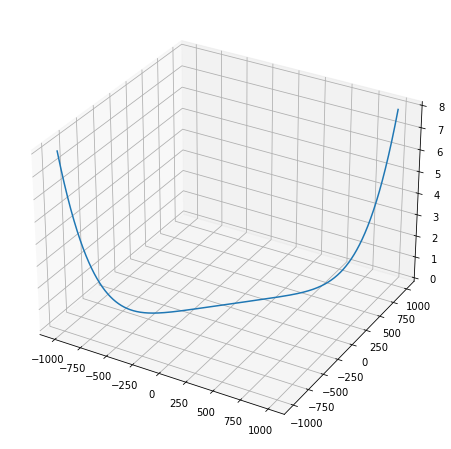

In [71]:
import numpy as np

from mpl_toolkits.mplot3d import  Axes3D
import matplotlib.pyplot as plt

%matplotlib inline


def f(x, y):
    return (x**2 + y**2)**3 - (x**2)*(y**3)

x = y = np.arange(-1000, 1000)
z = f(x, y)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")


Axes3D.plot(self=ax, xs=x,ys=y,zs=z)
plt.show()

In [72]:
class MissingPropertyRecord:
    def __getattr__(self, name):
        if name == "bad_name":
            raise AttributeError(f"{name} is missing")
            
            
            
data = MissingPropertyRecord()
data.bad_name

AttributeError: bad_name is missing

In [73]:
data = LoggingLazyRecort() # implemented __getattr__ method
print("Before:  ", data.__dict__)
print("Has first foo: ", hasattr(data, "foo"))
print("After:   ", data.__dict__)
print("Has second foo:  ", hasattr(data, "foo"))

Before:   {'exists': 5}
 * Called __getattr__('foo'), populating instance dicitonary
 * Returning 'Value for foo'
Has first foo:  True
After:    {'exists': 5, 'foo': 'Value for foo'}
Has second foo:   True


In [74]:
data = ValidatingRecord()
print("Has first foo : ", hasattr(data, "foo"))
print("Has second foo : ", hasattr(data, "foo"))

 * Called __getattribute__('foo')
 * Setting 'foo', to 'Value for foo'
Has first foo :  True
 * Called __getattribute__('foo')
 * Found 'foo' , returning 'Value for foo'
Has second foo :  True


In [76]:
class SavingRecord:
    def __setattr__(self, name, value):
        # preserve the data of Record
        super().__setattr__(name, value)
        
        
class LoggingSavingRecord(SavingRecord):
    def __setattr__(sef, name, value):
        print(f"* Called __setattr__({name!r}, {value!r})")
        super().__setattr__(name, value)
        
        
data = LoggingSavingRecord()
print("Before: ", data.__dict__)
data.foo = 5
print("After: ", data.__dict__)
data.foo = 7
print("Finally: ", data.__dict__)

Before:  {}
* Called __setattr__('foo', 5)
After:  {'foo': 5}
* Called __setattr__('foo', 7)
Finally:  {'foo': 7}


In [79]:
class BrokenDictionaryRecord:
    def __init__(self, data):
        self._data = {}
        
    def __getattribute__(self, name):
        print(f"* Called __getattribute__({name!r})")
        return self._data[name]

    
data = BrokenDictionaryRecord({"foo": 3})
data.foo

* Called __getattribute__('foo')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribute__('_data')
* Called __getattribut

RecursionError: maximum recursion depth exceeded while calling a Python object

In [81]:
class DictionaryRecord:
    def __init__(self, data):
        self._data = data
        
    def __getattribute__(self, name):
        print(f"* Called __getattribute__({name!r})")
        data_dict = super().__getattribute__("_data")
        return data_dict[name]
    
    
data = DictionaryRecord({"foo": 3})
print("foo: ", data.foo)

* Called __getattribute__('foo')
foo:  3


## 項目４８　サブクラスを "__ init __ subclass__" で検証する

* サブクラスの妥当性検証を行うメタクラスを定義する前に、
オブジェクトにおけるメタクラスの標準的な動作を理解しておくことが重要

In [82]:
class Meta(type):
    def __new__(meta, name, bases, class_dict):
        print(f"* Running {meta}.__new__ for {name}")
        print("Bases: ", bases)
        print(class_dict)
        return type.__new__(meta, name, bases, class_dict)
    
class MyClass(metaclass=Meta):
    stuff = 123
    
    def foo(self):
        pass
    
class MySubClass(MyClass):
    other = 567
    
    def bar(self):
        pass
    


* Running <class '__main__.Meta'>.__new__ for MyClass
Bases:  ()
{'__module__': '__main__', '__qualname__': 'MyClass', 'stuff': 123, 'foo': <function MyClass.foo at 0x12836ab80>}
* Running <class '__main__.Meta'>.__new__ for MySubClass
Bases:  (<class '__main__.MyClass'>,)
{'__module__': '__main__', '__qualname__': 'MySubClass', 'other': 567, 'bar': <function MySubClass.bar at 0x127572310>}


In [107]:
class ValidatePolygon(type):
    def __new__(meta, name, bases, class_dict):
        # validate only subclass of Polygon
        print(bases)
        if not isinstance(bases, object):
            if class_dict["sides"] < 3:
                raise ValueError("Polygons need 3+ sides")
        return type.__new__(meta, name, bases, class_dict)


class Polygon(object, metaclass=ValidatePolygon):
    sides = None # should specify in subclass
    
    @classmethod
    def interior_angles(cls):
        return (cls.sides - 2) * 180
    

class Triangle(Polygon):
    sides = 3


class Rectangle(Polygon):
    sides = 4


class Nonagon(Polygon):
    sides = 9


assert Triangle.interior_angles() == 180
assert Rectangle.interior_angles() == 360
assert Nonagon.interior_angles() == 1260

(<class 'object'>,)
(<class '__main__.Polygon'>,)
(<class '__main__.Polygon'>,)
(<class '__main__.Polygon'>,)


In [108]:
print("Before Class")

class Line(Polygon):
    print("Before sides")
    sides = 2
    print("After sides")
    
print("After class")

Before Class
Before sides
After sides
(<class '__main__.Polygon'>,)
After class


In [112]:
class BetterPolygon:
    sides = None # should specify in subclass
    
    # Implicity convert to a class method if this is defined as a instance method
    # When subclass is defined , this method runs , 
    # then class variable (sides) is validated
    def __init_subclass__(cls):
        super().__init_subclass__() # object.__init_subclass__
        print(cls)
        if cls.sides < 3:
            raise ValueError("Polygons need 3+ sides")
            
    @classmethod
    def interior_anagles(cls):
        return (cls.sides - 2) * 180
    

class Hexagon(BetterPolygon):
    sides = 6
    
assert Hexagon.interior_anagles() == 720

<class '__main__.Hexagon'>


In [113]:
print("Before class")

class Point(BetterPolygon):
    sides = 1
    
print("After class")

Before class
<class '__main__.Point'>


ValueError: Polygons need 3+ sides

In [114]:
class ValidateFilled(type):
    def __new__(meta, name, bases, class_dict):
        # validate subclass of Filled
        if bases:
            if class_dict["color"] not in ("red", "green"):
                raise ValueError("Fill color must be supported")
        return type.__new__(meta, name, bases, class_dict)
    

class Filled(metaclass=ValidateFilled):
    color = None # should specify in subclass

In [115]:
class RedPetagon(Filled, Polygon):
    color = "blue"
    sides = 5

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

In [116]:
class ValidatePolygon(type):
    def __new__(meta, name, bases, class_dict):
        # validate only class which is not root
        if not class_dict.get("is_root"):
            if class_dict["sides"] < 3:
                raise ValueError("Polygon need 3+ sides")
        return type.__new__(meta, name, bases, class_dict)
    
    
class Polygon(metaclass=ValidatePolygon):
    is_root = True
    sides = None # should specify in subclasses
    

class ValidateFilledPolygon(ValidatePolygon):
    def __new__(meta, name , bases, class_dict):
        # validate only class which is not root
        if not class_dict.get("is_root"):
            if class_dict["color"] not in ("red", "green"):
                raise ValueError("Fill color must be supported")
        return super().__new__(meta, name, bases, class_dict)
    

class FilledPolygon(Polygon, metaclass=ValidateFilledPolygon):
    is_root = True
    color = None # should specify in subclasses
    

In [118]:
class GreenPentagon(FilledPolygon):
    color = "green"
    sides = 5
    

greenie = GreenPentagon()
print(greenie)
assert isinstance(greenie, Polygon)

In [119]:
class OrangePentagon(FilledPolygon):
    color = "orange"
    sides = 5

ValueError: Fill color must be supported

In [120]:
class RedLine(FilledPolygon):
    color = "red"
    sides = 2

ValueError: Polygon need 3+ sides

In [121]:
class Filled:
    color = None # should specify in subclass
    
    def __init_subclass__(cls):
        super().__init_subclass__()
        if cls.color not in ("red", "green", "blue"):
            raise ValueError("Fills need a valid color")

In [122]:
class RedTriangle(Filled, Polygon):
    color = "red"
    sides = 3
    
    
ruddy = RedTriangle()
assert isinstance(ruddy, Filled)
assert isinstance(ruddy, Polygon)

## 項目49 クラスの存在を __ init _ subclass __で登録する

In [123]:
import json


class Serializable:
    def __init__(self, *args):
        self.args = args
        
    def serialize(self):
        return json.dumps({"args": self.args})
    

class Point2D(Serializable):
    def __init__(self, x, y):
        super().__init__(x, y)
        self.x = x
        self.y = y
        
        
    def __repr__(self):
        return f"Point2D({self.x}, {self.y})"
    
    
point = Point2D(5, 3)
print("Object:  ", point)
print("Serialized: ", point.serialize())

Object:   Point2D(5, 3)
Serialized:  {"args": [5, 3]}


In [127]:
# serialize : 複数の並列データを直列化して送信すること

class BetterSerializable:
    def __init__(self, *args):
        print(args)
        self.args = args
        
    def serialize(self):
        return json.dumps({
            "class": self.__class__.__name__,
            "args": self.args,
        })
    
    def __repr__(self):
        name = self.__class__.__name__
        args_str = ", ".join(str(x) for x in self.args)
        return f"{name}({args_str})"
            
registry = {}

def register_class(target_class):
    registry[target_class.__name__] = target_class

def deserialize(data):
    params = json.loads(data)
    name = params["class"]
    target_class = registry[name]
    return target_class(*params["args"])

    
class EventBetterPoint2D(BetterSerializable):
    def __init__(self, x, y):
        super().__init__(x, y)
        self.x = x
        self.y = y
        
        
        
register_class(EventBetterPoint2D)

In [128]:
before = EventBetterPoint2D(5, 3)
print("Before:  ", before)
data = before.serialize()
print("Serialized: ", data)
after = deserialize(data)
print("After: ", after)

(5, 3)
Before:   EventBetterPoint2D(5, 3)
Serialized:  {"class": "EventBetterPoint2D", "args": [5, 3]}
(5, 3)
After:  EventBetterPoint2D(5, 3)


In [131]:
class Point3D(BetterSerializable):
    def __init__(self, x, y, z):
        super().__init__(x, y, z)
        self.x = x
        self.y = y
        self.z = z
        

point = Point3D(5, 9, -4)
data = point.serialize()
deserialize(data)

(5, 9, -4)


KeyError: 'Point3D'

In [132]:
class Meta(type):
    def __new__(meta, name, bases, class_dict):
        cls = type.__new__(meta, name, bases, class_dict)
        register_class(cls)
        return cls
    

class RegisteredSerializable(BetterSerializable, metaclass=Meta):
    pass

In [135]:
class Vector3D(RegisteredSerializable):
    def __init__(self, x, y, z):
        super().__init__(x, y, z)
        self.x, self.y, self.z = x, y, z
        
        
before = Vector3D(10, -7, 3)
print("Before:  ", before)
data = before.serialize()
print("Serialized:  ", data)
print("After:  ", deserialize(data))

(10, -7, 3)
Before:   Vector3D(10, -7, 3)
Serialized:   {"class": "Vector3D", "args": [10, -7, 3]}
(10, -7, 3)
After:   Vector3D(10, -7, 3)


In [136]:
class BetterRegisteredSerializable(BetterSerializable):
    def __init_subclass__(cls):
        super().__init_subclass__()
        register_class(cls)
        
    
class Vector1D(BetterRegisteredSerializable):
    def __init__(self, magnitude):
        super().__init__(magnitude)
        self.magnitude = magnitude
        
        
before = Vector1D(6)
print("Before:  ", before)
data = before.serialize()
print("Serialized:  ", data)
print("After:   ", deserialize(data))

(6,)
Before:   Vector1D(6)
Serialized:   {"class": "Vector1D", "args": [6]}
(6,)
After:    Vector1D(6)


## 項目50 クラス属性に__ self_name __ で注釈を加える

* クラスが定義された後に実際に使われる前に属性を修正したり、注釈を加えたりする
* ディスクリプタを用いた包含するクラス内においてそれがどのように使われるかを調べる

In [137]:
class Field:
    def __init__(self, name):
        self.name = name
        self.internal_name = "_" + self.name
        
    def __get__(self, instance, instance_type):
        if instance is None:
            return self
        return getattr(instance, self.internal_name, "")
    
    def __set__(self, instance, value):
        setattr(instance, self.internal_name, value)
        

class Customer:
    # class property
    first_name = Field("first_name") # 冗長
    last_name = Field("last_name")
    prefix = Field("prefix")
    suffix = Field("suffix")
    
    
customer = Customer()
print(f"Before: {customer.first_name!r} {customer.__dict__}")
customer.first_name = "Euclid"
print(f"After: {customer.first_name!r} {customer.__dict__}")

Before: '' {}
After: 'Euclid' {'_first_name': 'Euclid'}


In [139]:
class Meta(type):
    def __new__(meta, name, bases, class_dict):
        for key, value in class_dict.items():
            if isinstance(value, Field):
                value.name = key
                value.internal_name = "_" + key
        cls = type.__new__(meta, name, bases, class_dict)
        return cls

In [141]:
# base class for using the meta class
class DatabaseRow(object, metaclass=Meta):
    pass

# the difference between using meta class and before is needless argument for constructer
class Field:
    def __init__(self):
        # these is assigned for a meta class
        self.name = None
        self.internal_name = None
        
    def __get__(self, instance, instance_type):
        if instance is None:
            return self
        return getattr(instance, self.internal_name, "")
    
    def __set__(self, instance, value):
        setattr(instance, self.internal_name, value)
        

class BetterCustomer(DatabaseRow):
    first_name = Field()
    last_name = Field()
    prefix = Field()
    suffix = Field()
    
    
cust = BetterCustomer()
print(f"Before: {cust.first_name!r} {cust.__dict__}")
cust.first_name = "Euler"
print(f"After: {cust.first_name!r} {cust.__dict__}")

Before: '' {}
After: 'Euler' {'_first_name': 'Euler'}


In [142]:
class BrokenCustomer:
    first_name = Field()
    second_name = Field()
    prefix = Field()
    suffix = Field()
    
    
cust = BrokenCustomer()
cust.first_name = "Mersenne"

TypeError: attribute name must be string, not 'NoneType'

In [147]:
# Descriptor
class Field:
    def __init__(self):
        self.name = None
        self.internal_name = None
        
    def __set_name__(self, owner, name):
        # when creating class, this method is called in every discrypta
        self.name = name
        self.internal_name = "_" + name
        
    def __get__(self, instance, instance_type):
        if instance is None:
            return self
        return getattr(instance, self.internal_name, "")
    
    def __set__(self, instance, value):
        setattr(instance, self.internal_name, value)
        


In [148]:
class FixedCustomer:
    first_name = Field()
    second_name = Field()
    prefix = Field()
    suffix = Field()
    
    
cust = FixedCustomer()
print(f"Before: {cust.first_name!r} {cust.__dict__}")
cust.first_name = "Mersenne"
print(f"After: {cust.first_name!r} {cust.__dict__}")

Before: '' {}
After: 'Mersenne' {'_first_name': 'Mersenne'}


* メタクラスはクラスが完全に定義される前に、クラス属性の修正を可能にする
* descryptorとメタクラスとは、宣言的な振る舞いと実行時イントロスペクションのための強力なコンピ
* descryptorクラスで__ set_name __を定義すると、取り囲むクラスとその属性名についての処理を行える
* descryptorがクラスインスタンスの階層において、扱うデータを直接調べることで、メモリリークと組み込みモジュールweakrefの両方を避けることができる